In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import csv
import warnings
from lifelines import KaplanMeierFitter
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_rows = 9999

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/nba-career/Data/master/player_data.csv')
df.head(20)

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974",San Jose State University
5,Shareef Abdur-Rahim,1997,2008,F,6-9,225.0,"December 11, 1976",University of California
6,Tom Abernethy,1977,1981,F,6-7,220.0,"May 6, 1954",Indiana University
7,Forest Able,1957,1957,G,6-3,180.0,"July 27, 1932",Western Kentucky University
8,John Abramovic,1947,1948,F,6-3,195.0,"February 9, 1919",Salem International University
9,Alex Abrines,2017,2018,G-F,6-6,190.0,"August 1, 1993",NaN


In [3]:
# convert data to floats
df['birth_date'] = pd.to_datetime (df['birth_date'])
df['year_start'] = 'December 1, ' + df['year_start'].astype(str)
df['year_start'] = pd.to_datetime (df['year_start'])
df['year_end'] = 'December 1, ' + df['year_end'].astype(str)
df['year_end'] = pd.to_datetime (df['year_end'])
df['entry_age'] = (df['year_start'] - df['birth_date'])
df['longevity'] = (df['year_end'] - df['year_start'])
df['entry_age'] = df['entry_age'].astype('timedelta64[D]')
df['longevity'] = df['longevity'].astype('timedelta64[D]')
df['entry_age'] = df['entry_age']/365
df['longevity'] = df['longevity']/365
df['longevity'] = (df['longevity']+1).astype('int')
df['active'] = (df['year_end'] != '2018-12-01').astype('int')

In [4]:
df.sample(20)

,name,year_start,year_end,position,height,weight,birth_date,college,entry_age,longevity,active
3964,Tom Thacker,1964-12-01,1971-12-01,G-F,6-2,170.0,1939-11-02,University of Cincinnati,25.098630,8,1
3167,Kosta Perovic,2008-12-01,2008-12-01,C,7-2,240.0,1985-02-19,NaN,23.797260,1,1
3491,Brandon Roy,2007-12-01,2013-12-01,G,6-6,215.0,1984-07-23,University of Washington,23.372603,7,1
736,Derrick Coleman,1991-12-01,2005-12-01,F,6-10,230.0,1967-06-21,Syracuse University,24.463014,15,1
4188,Kemba Walker,2012-12-01,2018-12-01,G,6-1,172.0,1990-05-08,University of Connecticut,22.583562,7,0
4495,Chris Wright,2012-12-01,2014-12-01,F,6-8,226.0,1988-09-30,University of Dayton,24.186301,3,1
680,John Chaney,1950-12-01,1950-12-01,F-C,6-3,185.0,1920-02-29,Louisiana State University,30.775342,1,1
1788,Charlie Hoefer,1947-12-01,1948-12-01,G,5-9,158.0,1921-09-16,Queens College,26.224658,2,1
4082,Elston Turner,1982-12-01,1989-12-01,G-F,6-5,190.0,1959-06-10,University of Mississippi,23.493151,8,1
798,Tyrone Corbin,1986-12-01,2001-12-01,G-F,6-6,210.0,1962-12-31,DePaul University,23.934247,16,1


In [5]:
df.dtypes

name                  object
year_start    datetime64[ns]
year_end      datetime64[ns]
position              object
height                object
weight               float64
birth_date    datetime64[ns]
college               object
entry_age            float64
longevity              int64
active                 int64
dtype: object

In [6]:
df.isna().sum()

name            0
year_start      0
year_end        0
position        1
height          1
weight          6
birth_date     31
college       302
entry_age      31
longevity       0
active          0
dtype: int64

In [7]:
# change college to bool then binary
df['college'] = df['college'].notnull().astype('int')

df = df.dropna()
df.isna().sum()

name          0
year_start    0
year_end      0
position      0
height        0
weight        0
birth_date    0
college       0
entry_age     0
longevity     0
active        0
dtype: int64

In [8]:
#convert height to float

new = df["height"].str.split("-", n = 1, expand = True).astype(float)
df['height'] = new[0] + (new[1]*(12/100))


In [9]:
# year_start to bins

bins =[pd.to_datetime('1940-12-01'), pd.to_datetime('1960-12-01'), pd.to_datetime('1970-12-01'), pd.to_datetime('1980-12-01'), pd.to_datetime('1990-12-01'), pd.to_datetime('2000-12-01'), pd.to_datetime('2010-12-01'), pd.to_datetime('2020-12-01')]
labels = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
df['year_start'] = pd.cut(df['year_start'], bins , labels = labels ,include_lowest =True)
print (df['year_start'].value_counts())





2000    687
1950    686
1990    668
1980    662
1970    656
2010    637
1960    518
Name: year_start, dtype: int64


In [10]:
df.dtypes

name                  object
year_start          category
year_end      datetime64[ns]
position              object
height               float64
weight               float64
birth_date    datetime64[ns]
college                int64
entry_age            float64
longevity              int64
active                 int64
dtype: object

In [11]:
# longevity to bins

bins =[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
df['longevity'] = pd.cut(df['longevity'], bins, labels = labels, include_lowest =True)
print (df['longevity'].value_counts())


0     1284
1      564
2      394
3      314
4      244
5      217
9      211
6      195
7      194
10     174
8      171
11     142
12     132
13     107
14      60
15      36
16      33
17      19
18      14
19       5
20       3
22       1
21       0
Name: longevity, dtype: int64


In [12]:
df.head()

,name,year_start,year_end,position,height,weight,birth_date,college,entry_age,longevity,active
0,Alaa Abdelnaby,1990,1995-12-01,F-C,7.20,240.0,1968-06-24,1,23.452055,4,1
1,Zaid Abdul-Aziz,1960,1978-12-01,C-F,7.08,235.0,1946-04-07,1,23.668493,9,1
2,Kareem Abdul-Jabbar,1960,1989-12-01,C,7.24,225.0,1947-04-16,1,23.643836,19,1
3,Mahmoud Abdul-Rauf,1990,2001-12-01,G,6.12,162.0,1969-03-09,1,22.745205,10,1
4,Tariq Abdul-Wahad,1990,2003-12-01,F,6.72,223.0,1974-11-03,1,24.093151,5,1


In [13]:
df = df[['name', 'year_start', 'position', 'height', 'weight', 'college', 'entry_age', 'longevity', 'active']].copy()
df.head()

,name,year_start,position,height,weight,college,entry_age,longevity,active
0,Alaa Abdelnaby,1990,F-C,7.20,240.0,1,23.452055,4,1
1,Zaid Abdul-Aziz,1960,C-F,7.08,235.0,1,23.668493,9,1
2,Kareem Abdul-Jabbar,1960,C,7.24,225.0,1,23.643836,19,1
3,Mahmoud Abdul-Rauf,1990,G,6.12,162.0,1,22.745205,10,1
4,Tariq Abdul-Wahad,1990,F,6.72,223.0,1,24.093151,5,1


In [14]:
#LifeLines
# Kaplan-Meier survival estimate
# set some plotting aesthetics, similar to ggplot
sns.set(palette = "colorblind", font_scale = 1.35, 
        rc = {"figure.figsize": (12,9), "axes.facecolor": ".92"})

In [15]:
kmf = KaplanMeierFitter() 

In [16]:
# The 1st arg accepts an array or pd.Series of individual survival times
# The 2nd arg accepts an array or pd.Series that indicates if the event 
# interest (or death) occured.
kmf.fit(durations = df.longevity, 
        event_observed = df.active)

<lifelines.KaplanMeierFitter: fitted with 4514 observations, 471 censored>

In [17]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,1284,1194,90,4514,4514
1,564,500,64,0,3230
2,394,348,46,0,2666
3,314,273,41,0,2272
4,244,211,33,0,1958
5,217,186,31,0,1714
6,195,170,25,0,1497
7,194,168,26,0,1302
8,171,151,20,0,1108


In [18]:
# The survival probabilities years 1-20
kmf.predict([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22])

0     0.735490
1     0.621637
2     0.540493
3     0.475548
4     0.424302
5     0.378257
6     0.335302
7     0.292037
8     0.252238
9     0.202167
10    0.158726
11    0.120770
12    0.084834
13    0.056149
14    0.038746
15    0.026878
16    0.017202
17    0.009830
18    0.004274
19    0.002849
20    0.000712
21    0.000356
22    0.000000
Name: KM_estimate, dtype: float64

In [19]:
# 50% of players are out of the league
kmf.median_

3.0

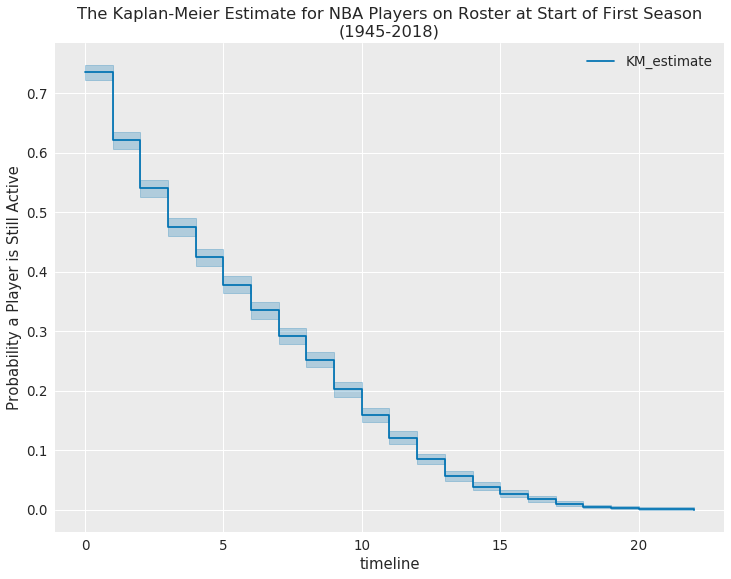

In [20]:
# plot the KM estimate
kmf.plot()
# Add title and y-axis label
plt.title("The Kaplan-Meier Estimate for NBA Players on Roster at Start of First Season\n(1945-2018)")
plt.ylabel("Probability a Player is Still Active")

plt.show()


In [21]:
df.position.value_counts() # get a count for each position

G      1565
F      1274
C       497
F-C     388
G-F     359
C-F     218
F-G     213
Name: position, dtype: int64

In [22]:
df.year_start.value_counts()

2000    687
1950    686
1990    668
1980    662
1970    656
2010    637
1960    518
Name: year_start, dtype: int64

In [32]:
def nba_life(df = df, positions = ['G', 'F', 'C', 'F-C', 'G-F', 'C-F', 'F-G'], decade = [1950, 1960, 1970, 1980, 1990, 2000, 2010]):
    selections1 = df[df.position.isin(positions)]
    selections2 = selections1[selections1.year_start.isin(decade)]
    kmf.fit(durations = selections2['longevity'], 
            event_observed = selections2['active'])
    table = kmf.predict([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22])
    return table

In [33]:
nba_life(df, positions = ['G'], decade = [1950, 1960])

0     0.518519
1     0.394180
2     0.320106
3     0.261905
4     0.211640
5     0.182540
6     0.153439
7     0.119048
8     0.097884
9     0.063492
10    0.042328
11    0.021164
12    0.015873
13    0.005291
14    0.002646
15    0.002116
16    0.001587
17    0.001058
18    0.000529
19    0.000000
20    0.000000
21    0.000000
22    0.000000
Name: KM_estimate, dtype: float64

In [25]:
def nba_life_plot(df = df, positions = ['G', 'F', 'C', 'F-C', 'G-F', 'C-F', 'F-G'], decade = [1950, 1960, 1970, 1980, 1990, 2000, 2010]):
    selections1 = df[df.position.isin(positions)]
    selections2 = selections1[selections1.year_start.isin(decade)]
    kmf.fit(durations = selections2['longevity'], 
            event_observed = selections2['active'])
    kmf.plot()
    plt.ylabel("Probability a Player is Still Active")
    plt.show()

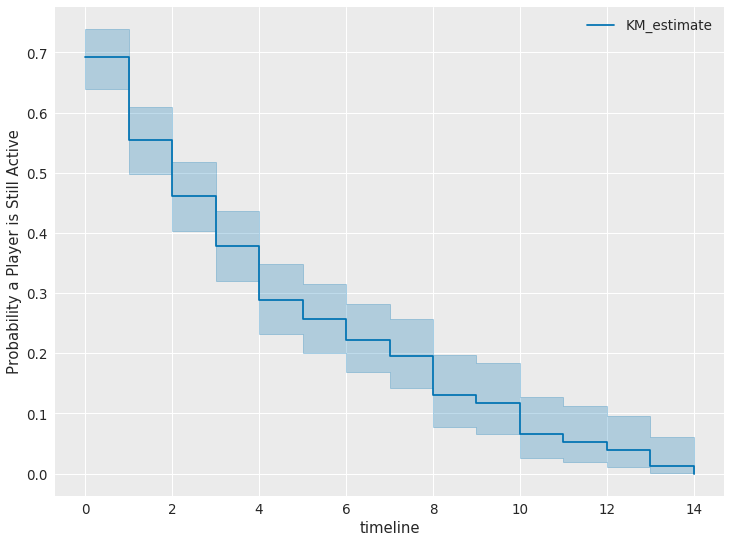

In [26]:
nba_life_plot(df, positions = ['F'], decade = [1960, 2010])

In [28]:
df.to_csv (r'/home/rick1270/repos/rclayton/Data/nba_data.csv', index = False, header=True)